In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Objectifs de la séance

- Compléter les données de l'API avec celles du webscraping
- Visualiser les données
- Nettoyer les données (regexp et nltk)
- Machine Learning "non-supervisé" : tagging automatique avec un tf-idf
- Amélioration de la prédiction de tags grâce à des méthodes de classifications binaires

## Compléter les données de l'API avec celles du webscraping

### Récupérer les données

Retrouver votre CONSUMER_KEY et votre ACCESS_TOKEN. Modifier les codes ci-dessous.

In [2]:
CONSUMER_KEY = "71268-0c68343bf8cd8c34e9029034"
ACCESS_TOKEN = "47d8c59a-c4f5-32be-f9f0-f3fabb"

On importe de nouveau les données du compte pocket.

In [3]:
import requests
from pprint import pprint

items = {
         "consumer_key":CONSUMER_KEY,
         "access_token":ACCESS_TOKEN,
         "detailsType": "complete"
        }

dict_pocket = requests.post('https://getpocket.com/v3/get', data = items).json()['list']

### En cas de probleme, vous pouvez importer les données à partir du .json

On va donc directement importer les données au format json.

In [1]:
import json
from pprint import pprint

with open('./data_pocket.json') as fp:    
    dict_pocket = json.load(fp)

pprint(dict_pocket)

{'1003565100': {'authors': {'55834601': {'author_id': '55834601',
                                         'item_id': '1003565100',
                                         'name': 'Grafikart.fr',
                                         'url': ''}},
                'excerpt': 'Ionic est un framework qui va vous permettre de '
                           'créer des applications mobiles en utilisant des '
                           'technologies Web. Ionic se base pour cela sur '
                           "d'autres frameworks / technologies qui ont fait "
                           'leurs preuves.  Avant de pouvoir commencer, il '
                           'nous faut évidemment commencer par installer '
                           "l'outil.",
                'favorite': '0',
                'given_title': 'Tutoriel Vidéo Apache Cordova Ionic Framework',
                'given_url': 'https://www.grafikart.fr/tutoriels/cordova/ionic-framework-641',
                'has_image': '0',
      

On créé une DataFrame avec les éléments souhaités (item_id, resolved_url, resolved_title, excerpt, tags).

### Mise en forme des données

In [2]:
dict_to_df = {}

keys = ['resolved_url', 'resolved_title', 'excerpt', 'tags']

for (k,v) in dict_pocket.items():
    dict_to_df[k] = dict(zip(keys, [v[key] for key in keys if key in v]))

In [3]:
import pandas as p
df_pocket = p.DataFrame.from_dict(dict_to_df, orient = "index")
df_pocket.head()

tags  \
1003565100  {'mobile app': {'item_id': '1003565100', 'tag'...   
1008275819  {'lewagon': {'item_id': '1008275819', 'tag': '...   
1011618630  {'data science': {'item_id': '1011618630', 'ta...   
1014684096  {'abtest': {'item_id': '1014684096', 'tag': 'a...   
1016233829  {'mdn': {'item_id': '1016233829', 'tag': 'mdn'...   

                                                 resolved_url  \
1003565100  https://www.grafikart.fr/tutoriels/cordova/ion...   
1008275819                            http://www.colorhunt.co   
1011618630  https://jakevdp.github.io/blog/2015/08/14/out-...   
1014684096  https://blog.dominodatalab.com/ab-testing-with...   
1016233829  https://developer.mozilla.org/en-US/docs/Learn...   

                                                      excerpt  \
1003565100  Ionic est un framework qui va vous permettre d...   
1008275819  Home Create Likes () About Add To Chrome Faceb...   
1011618630  In recent months, a host of new tools and pack...   
1014684096  In this post, I discuss a method for A/B testi...   
1016233829  Getting started with the Web is a concise seri...   

                                               resolved_title  
1003565100       Tutoriel Vidéo Apache CordovaIonic Framework  
1008275819                                         Color Hunt  
1011618630  Out-of-Core Dataframes in Python: Dask and Ope...  
1014684096     A/B Testing with Hierarchical Models in Python  
1016233829                       Getting started with the Web

On met en forme la colonne "tags".

In [4]:
df_pocket['tags'] = df_pocket['tags'].apply(lambda x: list(x.keys()) if x==x else x)
df_pocket.rename(columns = {'resolved_url':'url', 'resolved_title': 'title'}, inplace = True)
df_pocket.head()

tags  \
1003565100          [mobile app]   
1008275819             [lewagon]   
1011618630        [data science]   
1014684096              [abtest]   
1016233829  [mdn, documentation]   

                                                          url  \
1003565100  https://www.grafikart.fr/tutoriels/cordova/ion...   
1008275819                            http://www.colorhunt.co   
1011618630  https://jakevdp.github.io/blog/2015/08/14/out-...   
1014684096  https://blog.dominodatalab.com/ab-testing-with...   
1016233829  https://developer.mozilla.org/en-US/docs/Learn...   

                                                      excerpt  \
1003565100  Ionic est un framework qui va vous permettre d...   
1008275819  Home Create Likes () About Add To Chrome Faceb...   
1011618630  In recent months, a host of new tools and pack...   
1014684096  In this post, I discuss a method for A/B testi...   
1016233829  Getting started with the Web is a concise seri...   

                                                        title  
1003565100       Tutoriel Vidéo Apache CordovaIonic Framework  
1008275819                                         Color Hunt  
1011618630  Out-of-Core Dataframes in Python: Dask and Ope...  
1014684096     A/B Testing with Hierarchical Models in Python  
1016233829                       Getting started with the Web

### Regular expression 

Par [ici](http://www.xavierdupre.fr/app/ensae_teaching_cs/helpsphinx/notebooks/td2a_eco_5d_Travailler_du_texte_les_expressions_regulieres.html#td2aeco5dtravaillerdutextelesexpressionsregulieresrst).

Les expressions régulières (ou regular expression, regexp) servent à extraire des données de texte, ou à valider des données utilisateurs (lorsqu'un utilisateur rempli un formulaire par exemple).

Voici les principaux caractères à connaître.

<table>
    <thead>
        <th> Regexp </th>
        <th> Signification </th>
    </thead>
    <tbody>
        <tr>
            <td colspan=2> __Bases__ </td>
        </tr>
        <tr>
            <td> "a" </td>
            <td> a </td>
        </tr>
        <tr>
            <td colspan=2> __Quantificateurs__ </td>
        </tr>
        <tr>
            <td> "abc?" </td>
            <td> ab suivi par 0 ou 1 c </td>
        </tr>
        <tr>
            <td> "abc*" </td>
            <td> ab suivi par 0..∞ c </td>
        </tr>
        <tr>
            <td> "abc+" </td>
            <td> ab suivi par 1..∞ c </td>
        </tr>
        <tr>
            <td> "abc{3}" </td>
            <td> ab suivi par 3 c </td>
        </tr>
        <tr>
            <td colspan=2> __Groupes__ </td>
        </tr>
        <tr>
            <td> "(abc)+" </td>
            <td> 1..∞ abc </td>
        </tr>
        <tr>
            <td> "(a|b)c" </td>
            <td> ac ou bc </td>
        </tr>
        <tr>
            <td colspan=2> __Intervalles (type 1)__ </td>
        </tr>
        <tr>
            <td> "." </td>
            <td> n'importe quel caractère (un seul) </td>
        </tr>
        <tr>
            <td> "[aB9]" </td>
            <td> a ou B ou 9 </td>
        </tr>
        <tr>
            <td> "[0-9]" </td>
            <td> n'importe quel caractère numérique </td>
        </tr>
        <tr>
            <td> "[a-zA-Z]" </td>
            <td> n'importe quel caractère alphabétique </td>
        </tr>
        <tr>
            <td> "[^a-c]" </td>
            <td> n'importe quel caractère SAUF a, b et c </td>
        </tr>
        <tr>
            <td colspan=2> __Intervalles (type 2)__ </td>
        </tr>
        <tr>
            <td> "\d" </td>
            <td> comme "[0-9]" </td>
        </tr>
        <tr>
            <td> "\w" </td>
            <td> comme "[a-zA-Z0-9_]" </td>
        </tr>
        <tr>
            <td> "\W" </td>
            <td> comme "[^a-zA-Z0-9_]" </td>
        </tr>
        <tr>
            <td> "\s" </td>
            <td> espaces (" ", "\n", "\t", "\r") </td>
        </tr>
        <tr>
            <td> "\S" </td>
            <td> tout ce qui n'est pas un espace </td>
        </tr>
        <tr>
            <td colspan=2> __Ancres__ </td>
        </tr>
        <tr>
            <td> "^abc" </td>
            <td> commence par "abc" </td>
        </tr>
        <tr>
            <td> "^abc" </td>
            <td> commence par "abc" </td>
        </tr>
        <tr>
            <td> "abc$" </td>
            <td> termine par "abc" </td>
        </tr>
    </tbody>
</table>

Pour utiliser les regexp avec python, on fait appel au module "re", de la manière suivante : 

In [5]:
import re
string = "abc abccc abc ab bc"
print(re.compile("\w+").findall(string))

['abc', 'abccc', 'abc', 'ab', 'bc']


### Exercice 1

Extraire le domaine en utilisant des regexp. Le stocker dans un champs du DataFrame. Vous pouvez utiliser ce super outil : https://www.debuggex.com/

### Exercice 1 - correction

In [6]:
import re

def domain_extractor(url): 
    regex = re.compile("^((http|https)\:\/\/)?(www\.)?(.*)(\\.)((?!html|htm|php|asp|md|pdf)[a-z]{2,3})")
    try: 
        match_list = regex.findall(url)[0]
        return ''.join(match_list[-3:])
    except:
        return 'no_match'

In [7]:
df_pocket['domain']=df_pocket['url'].apply(lambda x: domain_extractor(x) )
#[print(d) for d in df_pocket['domain'][df_pocket['domain'].str.contains('/')]]
df_pocket[['url','domain']]

url  \
1003565100  https://www.grafikart.fr/tutoriels/cordova/ion...   
1008275819                            http://www.colorhunt.co   
1011618630  https://jakevdp.github.io/blog/2015/08/14/out-...   
1014684096  https://blog.dominodatalab.com/ab-testing-with...   
1016233829  https://developer.mozilla.org/en-US/docs/Learn...   
1028949272       http://lewagon.github.io/ui-components/#tabs   
1037787031        https://github.com/shakacode/react_on_rails   
1038434596                         http://alumni.lewagon.org/   
1045811499        https://www.youtube.com/watch?v=sleZ-hzrtRY   
1055285491  https://ponyfoo.com/articles/es6-promises-in-d...   
1056127688  http://nbviewer.jupyter.org/github/ptwobrussel...   
1057169119    http://blog.fouadhamdi.com/introduction-a-nltk/   
1058981102   https://market.mashape.com/imagesearcher/camfind   
1064802343  https://qbox.io/blog/building-an-elasticsearch...   
1068496952                           http://ban.jo/discovery/   
1072497525  http://www.mikesboyle.com/post/117202964694/py...   
1080754176  https://www.pubnub.com/blog/2015-04-30-google-...   
1086798403  https://blog.monkeylearn.com/the-definitive-gu...   
1087091031       https://github.com/lewagon/rails-stylesheets   
1090331523  http://adhdtechies.com/productivity-for-adhd-p...   
1091695147                          http://www.equityowl.com/   
1092282878                      https://reactforbeginners.com   
1099498384  https://www.softcover.io/books/28fdb94f/learn_...   
1107958074             https://www.mapbox.com/studio/welcome/   
1112590968           https://developer.wordpress.com/calypso/   
1124085481  https://medium.com/readme-mic/why-proxima-nova...   
1134763357  https://www.paybyphone.com/news/paybyphone-add...   
1156668216  http://www.programmableweb.com/news/google-wan...   
1159772242        https://www.youtube.com/watch?v=CHV9xTGD4Ws   
1162469194     https://dribbble.com/shots/2457200-Maps-UI-Kit   
...                                                       ...   
829788447             http://okomestudio.net/biboroku/?p=2375   
8325532         http://www.csie.ntu.edu.tw/~cjlin/papers.html   
833287792               https://pypi.python.org/pypi/munkres/   
836340574         https://www.youtube.com/watch?v=ab-_1diOUZU   
848141705       https://maptimeboston.github.io/d3-maptime/#/   
848484890   https://www.safaribooksonline.com/library/view...   
853282919   https://github.com/google/google-auth-library-...   
862030616       https://fr.wikipedia.org/wiki/Idriss_Aberkane   
872827786           http://codepen.io/andreasstorm/full/ClguF   
879382165                            https://www.recurse.com/   
887091950               http://es6-features.org/#PromiseUsage   
888836508         https://www.youtube.com/watch?v=K8dSKNB8vSo   
891252870   http://searchengineland.com/track-adwords-comp...   
893514277   https://developers.google.com/identity/protoco...   
897772388   http://www.appcoda.com/instagram-app-parse-swift/   
920375739   http://sebastien.saunier.me/blog/2015/05/10/gi...   
923449667                               http://artoolkit.org/   
92738558                            https://www.theverge.com/   
952475069   https://people.duke.edu/~ccc14/sta-663/Optimiz...   
954473465   https://infrequently.org/2015/06/progressive-a...   
956222891   http://joeltronics.github.io/got-book-show/boo...   
957402029   https://marcobonzanini.com/2015/06/16/mining-t...   
969693393   http://webmasters.stackexchange.com/questions/...   
972455959   https://developer.mozilla.org/en-US/docs/Web/A...   
978185723                             http://reactkungfu.com/   
982419639   https://developers.google.com/maps/documentati...   
988342741                                  https://flexbox.io   
989290193           http://ccoenraets.github.io/es6-tutorial/   
989889299   http://www.markhneedham.com/blog/2015/07/23/ne...   
992637806   https://www.paris.fr/services-et-infos-pratiqu...   

                           

### Ajout des données issues du webscraping

#### Contenu des pages présentes dans pocket

In [8]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import re

def words_htmltag(url):
    print(url)
    try: 
        html = requests.get(url).text
        soup = BeautifulSoup(html, 'lxml')
        words_dict = {}
        for html_tag in ['h1','h2','h3','p', 'article']:
            for e in soup.findAll(html_tag):
                text = e.get_text()
                words = re.split(r'\s+', text)
                # r'\s+' c est une expression reguliere.
                # celle-ci permet de splitter sur " ", "\t", "\n", "\r" meme s il y en a plusieurs d affilee
                words_dict[html_tag]=words 
        return words_dict
    except:
        return "scraper banned"

df_sample = df_pocket.ix[:]

df_sample['html_soup'] = df_sample['url'].apply(lambda x: words_htmltag(x))

https://www.grafikart.fr/tutoriels/cordova/ionic-framework-641
http://www.colorhunt.co
https://jakevdp.github.io/blog/2015/08/14/out-of-core-dataframes-in-python/
https://blog.dominodatalab.com/ab-testing-with-hierarchical-models-in-python/
https://developer.mozilla.org/en-US/docs/Learn/Getting_started_with_the_web
http://lewagon.github.io/ui-components/#tabs
https://github.com/shakacode/react_on_rails
http://alumni.lewagon.org/
https://www.youtube.com/watch?v=sleZ-hzrtRY
https://ponyfoo.com/articles/es6-promises-in-depth
http://nbviewer.jupyter.org/github/ptwobrussell/Mining-the-Social-Web-2nd-Edition/tree/master/ipynb/
http://blog.fouadhamdi.com/introduction-a-nltk/
https://market.mashape.com/imagesearcher/camfind
https://qbox.io/blog/building-an-elasticsearch-index-with-python
http://ban.jo/discovery/
http://www.mikesboyle.com/post/117202964694/python-nltk-wtf-chapter-1-notes-on-things-that
https://www.pubnub.com/blog/2015-04-30-google-maps-geolocation-tracking-in-realtime-with-java

In [10]:
df_sample.to_csv('./df_pocket.csv', index=False)

In [11]:
import pandas as p
import ast
df_sample = p.read_csv('./df_pocket.csv')
df_sample['html_soup'] = df_sample['html_soup'].apply(lambda x : ast.literal_eval(x) if x != "scraper banned" else x)
df_sample['tags'] = df_sample['tags'].apply(lambda x : ast.literal_eval(x) if x == x else x)
df_sample.head()

tags                                                url  \
0          [mobile app]  https://www.grafikart.fr/tutoriels/cordova/ion...   
1             [lewagon]                            http://www.colorhunt.co   
2        [data science]  https://jakevdp.github.io/blog/2015/08/14/out-...   
3              [abtest]  https://blog.dominodatalab.com/ab-testing-with...   
4  [mdn, documentation]  https://developer.mozilla.org/en-US/docs/Learn...   

                                             excerpt  \
0  Ionic est un framework qui va vous permettre d...   
1  Home Create Likes () About Add To Chrome Faceb...   
2  In recent months, a host of new tools and pack...   
3  In this post, I discuss a method for A/B testi...   
4  Getting started with the Web is a concise seri...   

                                               title                  domain  \
0       Tutoriel Vidéo Apache CordovaIonic Framework            grafikart.fr   
1                                         Color Hunt            colorhunt.co   
2  Out-of-Core Dataframes in Python: Dask and Ope...       jakevdp.github.io   
3     A/B Testing with Hierarchical Models in Python  blog.dominodatalab.com   
4                       Getting started with the Web   developer.mozilla.org   

                                           html_soup  
0  {'h2': ['Petit', 'tour', 'du', 'propriétaire']...  
1                                                 {}  
2  {'h2': ['Pubs', 'of', 'the', 'British', 'Isles...  
3  {'h2': ['Recent', 'Posts'], 'h1': ['Conclusion...  
4  {'h2': ['Mozilla'], 'h1': ['Getting', 'started...

#### Contenu des pages afférentes

In [62]:
! pip install scrapy

  Using cached Scrapy-1.4.0-py2.py3-none-any.whl
  Using cached service_identity-17.0.0-py2.py3-none-any.whl
  Using cached cssselect-1.0.1-py2.py3-none-any.whl
  Using cached w3lib-1.18.0-py2.py3-none-any.whl
  Using cached parsel-1.2.0-py2.py3-none-any.whl
  Using cached queuelib-1.4.2-py2.py3-none-any.whl
  Using cached hyperlink-17.3.1-py2.py3-none-any.whl
  Using cached constantly-15.1.0-py2.py3-none-any.whl
  Using cached zope.interface-4.4.3-cp35-cp35m-manylinux1_x86_64.whl
  Using cached incremental-17.5.0-py2.py3-none-any.whl
  Using cached Automat-0.6.0-py2.py3-none-any.whl
  Using cached pyasn1_modules-0.1.5-py2.py3-none-any.whl
  Using cached attrs-17.2.0-py2.py3-none-any.whl


Si vous ne parvenez pas à installer scrapy, aller dans le terminal et taper : `conda install -c conda-forge scrapy`

In [63]:
! rm -rf './scrapy.json' #supprime les eventuelles versions precedentes de scrapy.json

In [14]:
import scrapy
from scrapy.crawler import CrawlerProcess
    
class Content_Spider(scrapy.Spider):
    name = 'pocket_spider'
    start_urls = list(df_sample['url'])
    allowed_domains = list(df_sample['domain'])

    custom_settings = {'FEED_FORMAT' : 'jsonlines',
                        'FEED_URI' : 'scrapy.json', 
                       # le nom du fichier json dépend du moment où on lance le code
                        'FEED_EXPORT_ENCODING' : 'utf-8',
                        'DEPTH_LIMIT': 1,
                        'DEPTH_PRIORITY': 1,
                        'LOG_ENABLED' : False
                      }    
    
    def parse(self, response):
        
        for e in response.css('body'):
            yield {
                "url": response.request.url, # url de depart : sera une clé de jointure pour la suite
                "h1" : [s.strip() for s in e.css("h1::text").extract() if s.strip() != ""],
                "h2" : [s.strip() for s in e.css("h2::text").extract() if s.strip() != ""],
                "h3" : [s.strip() for s in e.css("h3::text").extract() if s.strip() != ""],
                "p" : [s.strip() for s in e.css("p::text").extract() if s.strip() != ""]
            }
                
        for a in response.css('body a::attr(href)').extract():
            if (a is not None):
                yield response.follow(a, callback=self.parse)

In [15]:
process = CrawlerProcess({
    'USER_AGENT': 'Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1)'
})

process.crawl(Content_Spider)
process.start(stop_after_crawl=True)

2017-10-21 15:15:29 [scrapy.utils.log] INFO: Scrapy 1.4.0 started (bot: scrapybot)
2017-10-21 15:15:29 [scrapy.utils.log] INFO: Overridden settings: {'USER_AGENT': 'Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1)'}


In [16]:
list_scrapy = []
with open('./scrapy.json') as f:
    for line in f:
        list_scrapy.append(json.loads(line))

In [17]:
list_scrapy[0]

{'h1': ["\n  Le Wagon's components\n", 'Le Wagon Berlin'],
 'h2': ['Getting started',
  '\n          ',
  '\n',
  '        ',
  '\n          ',
  '\n',
  '        ',
  '\n          ',
  '\n',
  '        ',
  '\n          ',
  '\n',
  '        ',
  'Le Wagon Shanghai',
  'Le Wagon Copenhagen',
  'Le Wagon Lisbon',
  'Le Wagon Sao Paulo',
  '\n          Messages\n',
  '        ',
  '\n          ',
  '\n',
  '        ',
  '\n          ',
  '\n',
  '        ',
  '\n          ',
  '\n',
  '        ',
  '\n          ',
  '\n',
  '        '],
 'h3': ['Combined with Bootstrap grid',
  'Gab Dehan',
  'Cecile Veneziani',
  'Tabs',
  '350',
  '456',
  '189',
  '13',
  'Basics product',
  'Kudoz',
  'Product with image',
  'Kudoz',
  'Hidden controls',
  'Kudoz'],
 'p': ['Add a new CSS file (e.g.',
  ') in your',
  ', copy/paste our CSS, then use the HTML code of the components wherever you want. Here are available components:',
  'A very simple component. Feel free to code your own variants. Here

TO-DO: format souhaité : un json par url de df_pocket avec url_parent: ,url: ,h1: [], h2: [], h3:[], p:[]. Si url de depart, url_parent est vide.

### Exercice 2 

Extraire tous les domaines et faire la jointure de ces nouvelles données avec df_pocket. On veut un dictionnaire avec l'ensemble des informations (h1:[], h2:[], h3:[], p:[], url:[]) 

## Visualiser les données

Avant de sortir des statsitiques sur les termes que nous avons récupéré, il peut etre utile de les visualiser. Cela donne toujours des idées de voir les données. Pour cela on va utiliser la librairie [wordcloud](https://github.com/amueller/word_cloud).

In [9]:
! pip install wordcloud

    100% |████████████████████████████████| 174kB 1.3MB/s 
  Running setup.py bdist_wheel for wordcloud ... - \ | done
  Stored in directory: /home/athean/.cache/pip/wheels/d9/4c/ac/e63c45f2ce09860e9459a410953039c30296e89d9f7234675f
Successfully built wordcloud


In [15]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [26]:
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)
print(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white")

{'her', 'she', 'this', 'then', 'above', 'else', 'but', 'which', "can't", "we'll", "that's", 'whom', "where's", 'as', "wasn't", 'can', 'doing', 'yourself', "how's", 'down', 'when', 'i', "weren't", "isn't", 'under', 'them', 'once', "doesn't", "let's", "it's", 'over', 'r', 'an', "wouldn't", "you'd", 'very', 'being', 'like', "i'd", "we'd", 'should', "couldn't", 'all', 'do', 'ourselves', 'him', "they'll", 'into', 'it', 'on', "we've", 'yours', 'did', 'shall', "they'd", 'having', 'to', 'was', 'about', "shan't", 'and', 'me', "i'll", "he'd", 'had', 'during', 'ours', 'for', "she'd", 'yourselves', "won't", 'http', 'were', 'against', "didn't", 'out', 'most', 'or', "you're", 'after', 'until', 'cannot', "what's", 'a', 'ought', "hadn't", 'their', 'because', 'does', 'could', 'k', 'that', "we're", "she's", 'only', 'by', 'so', "i'm", 'herself', 'any', "you've", 'would', 'each', 'before', 'some', 'nor', 'not', 'same', 'are', "i've", 'other', 'than', 'we', 'be', "why's", 'own', 'these', 'more', 'my', "he'

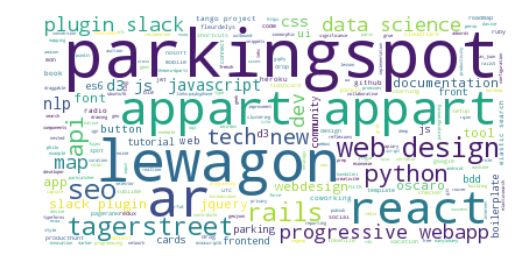

In [29]:
tags_string = ' '.join(df_sample['tags'].apply(lambda x: ' '.join(x) if x==x else ''))
wordcloud.generate(tags_string)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Exercice 2

### Exercice 2 - 1

Pour les webmasters qui cherchent à optimiser le référencement de leur site dans le moteur de recherche Google, il est important d'avoir une cohérence des termes utilisés dans les titles, balises h1 et urls. Faire des wordcloud sur ces champs et voir si c'est respecté ici.

### Exercice 2 - 2

Analyser les termes présents dans les champs h2, h3, et p de html_soup et, dans l'excerpt. A votre avis, faudra-t-il donner le même poids aux mots contenus dans ces champs qu'à ceux contenus dans les h1, title et urls ? Si certains mots fréquents vous surprennent, il peut s'agir d'un biais dans les sites bookmarqués : n'hésitez pas à lister les urls correspondantes !

### Exercice 2 - 3

En se restreignant aux urls qui ont des tags, comparer les nuages des mots contenus dans les champs h1, title et urls avec les tags. Qu'en déduisez-vous ?

Astuce:  Penser à étoffer les stopwords en fonction des résultats (par exemple, il y a beaucoup "de", "le", "la" (l'objet STOPWORDS proposé dans wordcloud est en anglais).

### Exercice 2 - correction

Stopwords améliorés:

In [146]:
for wds in ['http', 'https', 'www', 'fr', 'com', 'io', 'org', 'co', 'jo', 'edu', 'news', 'html', 'htm',\
            'github', 'youtube', 'google', 'blog', 'watch', 'de', 'le', 'la', 'en', 'sur', 'vous', 'les', \
           'ajouter', 'README', 'md', 'et', 'PROCESS', 'CMYK', 'des', 'chargement', 'playlists', 'endobj', \
           'obj','est', 'use', 'using', 'will', 'web', 'first','pour', 'du', 'une', 'que']:
    stopwords.add(wds)

### Exercice 2 - 1 - correction

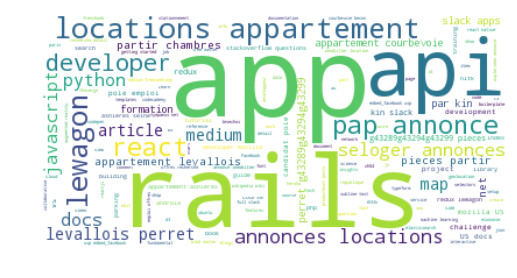

In [211]:
def url_cleaning(url):
    return ' '.join(re.split(r'\/|\.|\:|-|\?',url))

url_string = ' '.join(df_sample['url'].apply(lambda x : url_cleaning(x)))
wordcloud.generate(url_string)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

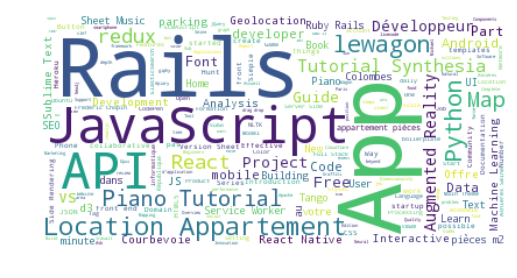

In [228]:
def nan_to_string(x):
    if x==x:
        return x
    else:
        return ''

title_string = ' '.join(df_sample['title'].apply( lambda x: nan_to_string(x)))
wordcloud.generate(title_string)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

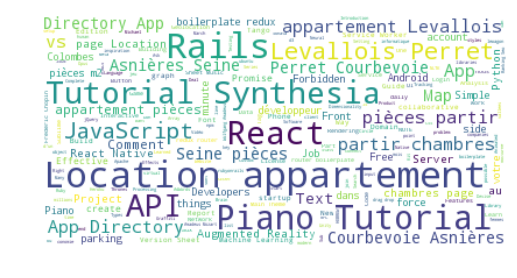

In [224]:
def hx_cleaning(d,hx):
    if str(hx) in d:
        return ' '.join(d[str(hx)])
    else: 
        return ''
     
h1_string = ' '.join(df_sample['html_soup'].apply(lambda x : hx_cleaning(x,'h1')))
wordcloud.generate(h1_string)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [247]:
df_sample['h1'] = df_sample['html_soup'].apply(lambda x : ' '.join(x['h1']) if 'h1' in x else '')
df_sample['domain'][df_sample['h1'].str.contains('Tutorial')]

8               youtube.com
47              youtube.com
51              youtube.com
60              youtube.com
63              youtube.com
119             youtube.com
121             youtube.com
185             youtube.com
353             youtube.com
415             youtube.com
430             youtube.com
442             youtube.com
450             youtube.com
466    ccoenraets.github.io
Name: domain, dtype: object

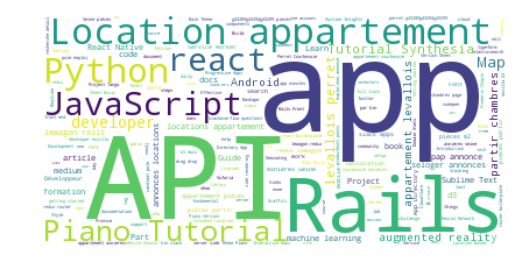

In [217]:
seo_string = ' '.join([url_string, title_string, h1_string])
wordcloud.generate(seo_string)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Conclusion: les title et les urls sont cohérentes. Meilleure structure des balises h1 pour les sites de logement => écrase visuellement les h1 des autres sites.

### Exercice 2 - 2 - correction

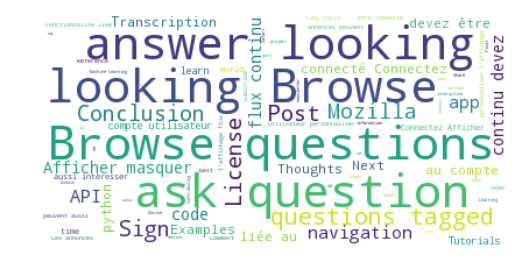

In [225]:
h2_string = ' '.join(df_sample['html_soup'].apply(lambda x : hx_cleaning(x,'h2')))
wordcloud.generate(h2_string)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [220]:
df_sample['h2'] = df_sample['html_soup'].apply(lambda x : ' '.join(x['h2']) if 'h2' in x else '')
df_sample['domain'][df_sample['h2'].str.contains('Browse')]

73                stackoverflow.com
92                    askubuntu.com
174               stackoverflow.com
226               stackoverflow.com
357               stackoverflow.com
360               stackoverflow.com
363           visionmedia.github.io
416               stackoverflow.com
461    webmasters.stackexchange.com
Name: domain, dtype: object

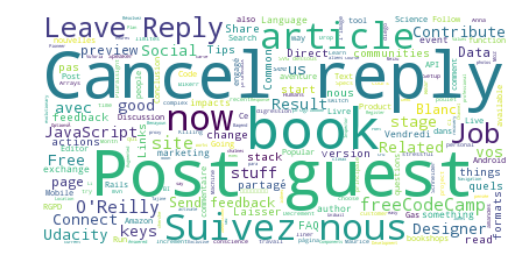

In [226]:
h3_string = ' '.join(df_sample['html_soup'].apply(lambda x : hx_cleaning(x, 'h3')))
wordcloud.generate(h3_string)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [129]:
df_sample['h3'] = df_sample['html_soup'].apply(lambda x : ' '.join(x['h3']) if 'h3' in x else '')
df_sample['domain'][df_sample['h3'].str.contains('Cancel')]

149           mathiasp.fr
229           zuehlke.com
245         kevinbinz.com
255      marketoonist.com
405            mlwave.com
460    marcobonzanini.com
Name: domain, dtype: object

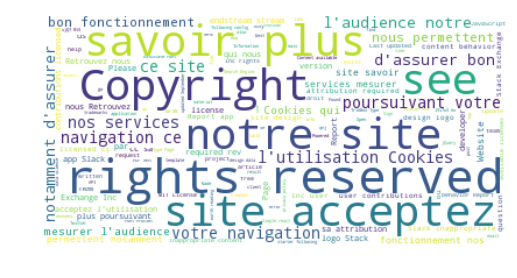

In [227]:
def p_cleaning(x):
    if (type(x) == dict) & ('p' in x ):
        return ' '.join(x['p'])
    else: 
        return ''

p_string = ' '.join(df_sample['html_soup'].apply(lambda x : p_cleaning(x)))
wordcloud.generate(p_string)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [134]:
df_sample['p'] = df_sample['html_soup'].apply(lambda x : ' '.join(x['p']) if (type(x) == dict) & ('p' in x ) else '')
sorted(df_sample['domain'][df_sample['p'].str.contains('web')])

['code.tutsplus.com',
 'flexbox.io',
 'fontsquirrel.com',
 'fontsquirrel.com',
 'frenchweb.fr',
 'frenchweb.fr',
 'frenchweb.job',
 'github.com',
 'github.com',
 'market.mashape.com',
 'medium.com',
 'paybyphone.com',
 'producthunt.com',
 'redis.io',
 'statstool.com',
 'statstool.com']

Conclusion: h2, h3, et p : champ sémantique très éloigné des urls, title et balises h1. Cela provient d'un biais dans les sites bookmarqués (les sites stackoverflow par exemple, sont caractérisés par le fait d'indiquer le mot "Browse" dans une balise h2). Par ailleurs, ces balises ne semblent pas attirer de mots qui pourraient faire l'objet d'un tag automatique. Mieux vaut se concentrer sur les title et url.

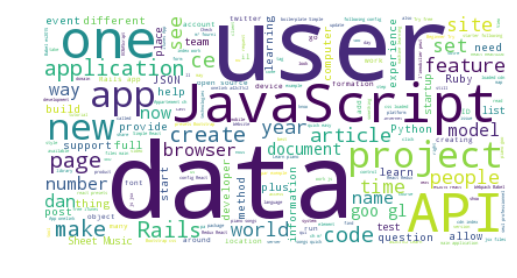

In [230]:
excerpt_string = ' '.join(df_sample['excerpt'].apply( lambda x: nan_to_string(x)))
wordcloud.generate(excerpt_string)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Mots génériques. Un tf-idf va nous aider à faire ressortir les mots spécifiques.

### Exercice 2 - 3 - correction

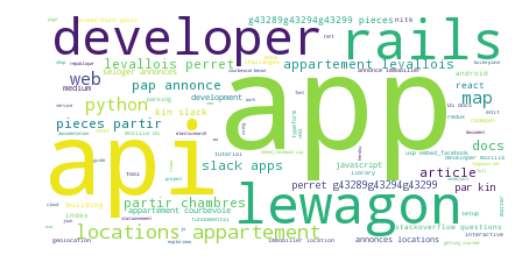

In [109]:
url_string_iftags = ' '.join(df_sample['url'][df_sample['tags'] == df_sample['tags']].apply(lambda x : ' '.join(re.split(r'\/|\.|\:|-|\?',x))))
wordcloud.generate(url_string_iftags)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

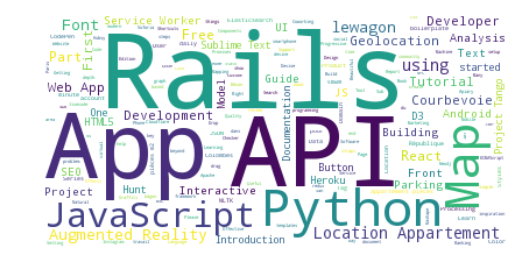

In [110]:
title_string_iftags = ' '.join(df_sample['title'][df_sample['tags'] == df_sample['tags']].apply( lambda x: x if x==x else ''))
wordcloud.generate(title_string_iftags)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

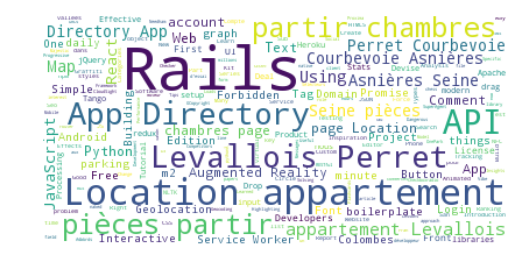

In [111]:
h1_string_iftags = ' '.join(df_sample['html_soup'][df_sample['tags'] == df_sample['tags']].apply(lambda x : ' '.join(x['h1'] if 'h1' in x else '')))
wordcloud.generate(h1_string_iftags)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

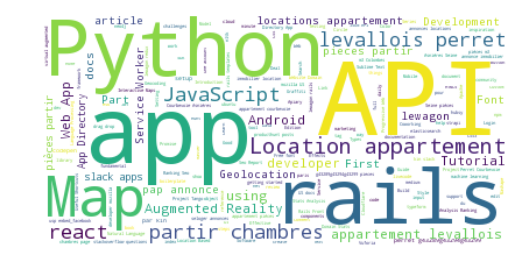

In [112]:
seo_string_iftags = ' '.join([url_string_iftags, title_string_iftags, h1_string_iftags])
wordcloud.generate(seo_string_iftags)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

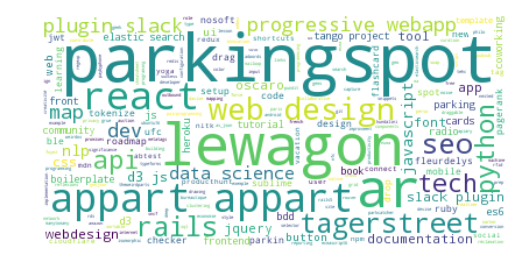

In [113]:
tags_string = ' '.join(df_sample['tags'].apply(lambda x: ' '.join(x) if x==x else ''))
wordcloud.generate(tags_string)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Conclusion : il y a des spécificités dans la manière de tagger. Pour le dire autrement, il y a de fortes chances pour que ces contenus ne soient pas faciles à trouver dans google avec les mots-clés indiqués dans tags :) Soit parce que c'est "mal taggé", soit parce c'est "mal ranké" par Google, soit (hypothèse la plus plausible) : parce qu'il y a un biais dans l'utilisation de l'application pocket : on ne bookmarque que ce qu'il est difficile de trouver dans le web => nécessité d'un classificateur personnalisé.

## Nettoyer les données (regexp et nltk)

Mais avant tout, nous devrions augmenter la qualité de nos données (en améliorant les parsers et la liste des stopwords). C'est l'objet de cette section.

In [191]:
words = ' '.join([title_string,url_string,h1_string,h2_string,h3_string,excerpt_string])
# on ne conserve que les mots
words_string = re.sub('[^A-Za-z ]','', words)
#on "nettoie les espaces"
words_string = re.sub('\s+',' ', words_string)
words_string

'Tutoriel Vido Apache CordovaIonic Framework Color Hunt OutofCore Dataframes in Python Dask and OpenStreetMap AB Testing with Hierarchical Models in Python Getting started with the Web Le Wagon UI components Le Wagon Alumni ES Promises in Depth Jupyter Notebook Viewer Introduction lanalyse de texte avec nltk Tokenization CamFind API Documentation Build an Elasticsearch Index with PythonMachine Learning Series Part The MustHave Discovery Tool for every Media Professional Python NLTK WTF Chapter Notes on things that dont work right Google Maps Geolocation Tracking in Realtime with JavaScript The Definitive Guide to Natural Language Processing lewagonrailsstylesheets React For Beginners Learn Enough Text Editor to Be Dangerous Michael Hartl Mapbox The New WordPresscom Why Proxima Nova Is Everywhere PayByPhone Adds NFC in San Fran Google Wants to Fund App Developers for Project Tango Phone Project Tango Virtual and Augmented Reality for Mobile Phones Ubiquity Dev Summit Maps UI Kit OnePark

In [149]:
! pip install nltk

Nltk contient un corpus de stopwords en plusieurs langues. On peut enrichir la liste déjà créée.

In [193]:
stopwords_fr_ntlk = set(nltk.corpus.stopwords.words('french'))
stopwords_en_ntlk = set(nltk.corpus.stopwords.words('english'))
stopwords_clean = [ l.lower() for l in list(stopwords.union(stopwords_fr_ntlk).union(stopwords_en_ntlk))]
stopwords_clean

['ayants',
 'shouldn',
 'this',
 'ayons',
 'mes',
 'above',
 'pas',
 'but',
 'un',
 "can't",
 'ain',
 "we'll",
 'co',
 'edu',
 'mustn',
 'whom',
 'playlist',
 "where's",
 'ses',
 'aviez',
 'fussiez',
 'can',
 'doing',
 'yourself',
 "how's",
 'étais',
 'n',
 'auras',
 'qui',
 'now',
 "isn't",
 'under',
 'using',
 'aurons',
 'them',
 'once',
 "doesn't",
 'sur',
 'des',
 'je',
 'fûmes',
 'aurions',
 "it's",
 'google',
 'will',
 'over',
 'r',
 'news',
 'vous',
 'ont',
 'an',
 "wouldn't",
 'https',
 'même',
 'very',
 'being',
 'like',
 "i'd",
 "we'd",
 'toi',
 'should',
 "couldn't",
 'all',
 'him',
 'mon',
 'into',
 "we've",
 'did',
 'eut',
 'shall',
 'ma',
 'having',
 'nous',
 'was',
 'about',
 "shan't",
 'and',
 'blog',
 'me',
 'had',
 'qu',
 'seraient',
 'étaient',
 'aie',
 'ours',
 'soient',
 "won't",
 'http',
 'were',
 'against',
 'elle',
 'mightn',
 'fussions',
 'most',
 'or',
 'avait',
 'fussent',
 'fut',
 'ta',
 'd',
 'ait',
 'aren',
 'une',
 'ou',
 'ought',
 'eût',
 "hadn't",
 'the

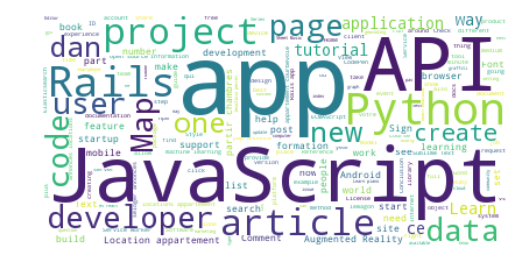

In [209]:
wordcloud.generate(words_string)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

On applique tout ça à df_sample.

In [243]:
def words_cleaning(url,title,excerpt,html_soup):
    url_clean = url_cleaning(url)
    title_clean = nan_to_string(title)
    excerpt_clean = nan_to_string(excerpt)
    h1_clean = hx_cleaning(html_soup,'h1')
    h2_clean = hx_cleaning(html_soup,'h2')
    h3_clean = hx_cleaning(html_soup,'h3')
    p_clean = p_cleaning(html_soup)
    words = ' '.join([url_clean, title_clean, excerpt_clean, h1_clean, h2_clean, h3_clean, p_clean])
    words_clean = re.sub('[^A-Za-z ]','', words)
    words_clean = re.sub('\s+',' ', words_clean)
    words_list = words_clean.split(' ')
    return ' '.join([w.lower() for w in words_list if w not in stopwords_clean])

In [246]:
df_sample['words_string'] = np.vectorize(words_cleaning)(df_sample['url'], \
                                                         df_sample['title'], \
                                                         df_sample['excerpt'], \
                                                         df_sample['html_soup'])
df_sample.head()

tags                                                url  \
0          [mobile app]  https://www.grafikart.fr/tutoriels/cordova/ion...   
1             [lewagon]                            http://www.colorhunt.co   
2        [data science]  https://jakevdp.github.io/blog/2015/08/14/out-...   
3              [abtest]  https://blog.dominodatalab.com/ab-testing-with...   
4  [mdn, documentation]  https://developer.mozilla.org/en-US/docs/Learn...   

                                             excerpt  \
0  Ionic est un framework qui va vous permettre d...   
1  Home Create Likes () About Add To Chrome Faceb...   
2  In recent months, a host of new tools and pack...   
3  In this post, I discuss a method for A/B testi...   
4  Getting started with the Web is a concise seri...   

                                               title                  domain  \
0       Tutoriel Vidéo Apache CordovaIonic Framework            grafikart.fr   
1                                         Color Hunt            colorhunt.co   
2  Out-of-Core Dataframes in Python: Dask and Ope...       jakevdp.github.io   
3     A/B Testing with Hierarchical Models in Python  blog.dominodatalab.com   
4                       Getting started with the Web   developer.mozilla.org   

                                           html_soup  \
0  {'h2': ['Petit', 'tour', 'du', 'propriétaire']...   
1                                                 {}   
2  {'h2': ['Pubs', 'of', 'the', 'British', 'Isles...   
3  {'h2': ['Recent', 'Posts'], 'h1': ['Conclusion...   
4  {'h2': ['Mozilla'], 'h1': ['Getting', 'started...   

                           h2                 h3  \
0  Petit tour du propriétaire     La compilation   
1                                                  
2  Pubs of the British Isles¶       Dask Arrays¶   
3                Recent Posts            Related   
4                     Mozilla  How the web works   

                                                   p  \
0                                                      
1                                                      
2  This post was written entirely in the IPython ...   
3                           Get Data Science Updates   
4         Content is available under these licenses.   

                                        words_string  
0  grafikart tutoriels cordova ionic framework tu...  
1  colorhunt color hunt home create likes about a...  
2  jakevdp core dataframes python outofcore dataf...  
3  dominodatalab ab testing hierarchical models p...  
4  developer mozilla us docs learn gettingstarted...

## Natural Language Processing et tf-idf

Lire [introduction au NLP](http://www.xavierdupre.fr/app/ensae_teaching_cs/helpsphinx/notebooks/td2a_TD5_Traitement_automatique_des_langues_en_Python.html#td2atd5traitementautomatiquedeslanguesenpythonrst)

### Exercice 4

S'inspirer de [introduction à nltk](http://www.xavierdupre.fr/app/ensae_teaching_cs/helpsphinx/notebooks/td2a_TD5_Traitement_automatique_des_langues_en_Python.html#introduction-a-nltk) et analyser les principaux termes de recherche des documents.

### Exercice 4 - correction

In [245]:
import re, nltk
#Tokenisation naïve sur les espaces entre les mots => on obtient une liste de mots
tokens = re.split('\s+', ' '.join(df_sample['words_string']))

#On transforme cette liste en objet nltk "Text" (objet chaine de caractère qui conserve la notion de tokens, et qui 
#comprend  un certain nombre de méthodes utiles pour explorer les données.
text = nltk.Text(tokens)

#Comme par exemple "concordance" : montre les occurences d'un mot dans son contexte
print("Exemples d'occurences du terme 'python' :")
text.concordance("python")
print('\n')

# Analyse de la fréquence des termes d'intérêt 
fdist = text.vocab()
print("Co-occurences fréquentes :")
text.collocations()
print('\n')

print("Nombre de mots :", len(tokens))
print('\n')
print("Nombre de mots uniques :",len(fdist.keys()))
print('\n')
print("Nombre d'occurences du terme 'github' :",fdist["github"])
print("Nombre d'occurences du terme 'python' :",fdist["python"])
print("Nombre d'occurences du terme 'javascript' :",fdist["javascript"])
print("Nombre d'occurences du terme 'rails' :",fdist["rails"])
print("Nombre d'occurences du terme 'data' :", fdist["source"])
print("Nombre d'occurences du terme 'web' :", fdist["web"])
print("Nombre d'occurences du terme 'API' :",fdist["API"])
print('\n')

#10 tokens les plus fréquents
top100_items = sorted(fdist.items(),key=lambda x: x[1],reverse=True)[:100]
#sans les fréquences
top100 = [t[0] for t in top100_items]
print("Top 100 :", top100)
print('\n')

#sans les termes trop frequents ("stopwords")
top100_without_stopwords = [w for w in top100 if w.lower() \
                         not in stopwords_clean]
print("Top 100 sans les mots fréquents :", top100_without_stopwords)
print('\n')

# Enumerate the frequency distribution
for rank, word in enumerate(sorted(fdist.items(),key=lambda x: x[1],reverse=True)):
    if word[0].lower() not in stopwords_clean:
        print(rank, word)
        if rank > 75:
            print("....")
            break

Exemples d'occurences du terme 'python' :
Displaying 25 of 52 matches:
wed hunters jakevdp core dataframes python outofcore dataframes python dask op
aframes python outofcore dataframes python dask openstreetmap in recent months
ckages announced working data scale python for excellent entertaining summary 
mary id suggest watching rob storys python data bikeshed talk pydata seattle c
alab ab testing hierarchical models python ab testing hierarchical models pyth
thon ab testing hierarchical models python in post i discuss method ab testing
te nltk tokenization nltk librairie python trs utile manipuler texte market ma
s qbox building elasticsearch index python build elasticsearch index pythonmac
volving world media mikesboyle post python nltk wtf chapter notes things pytho
ython nltk wtf chapter notes things python nltk wtf chapter notes things dont 
orpus linguistics fan learning code python excellent online tutorial called na
 called natural language processing python also book buy cas

### Exercice 5 

S'inspirer de [tf-idf à la main](http://www.xavierdupre.fr/app/ensae_teaching_cs/helpsphinx/notebooks/td2a_TD5_Traitement_automatique_des_langues_en_Python.html#analyse-des-donnees-textuelles-td-idf-similarite-cosine-et-n-grams) ou de [tf-idf avec nltk](http://www.xavierdupre.fr/app/ensae_teaching_cs/helpsphinx/notebooks/td2a_TD5_Traitement_automatique_des_langues_en_Python.html#requeter-les-donnees-google-avec-tf-idf) et faire un moteur de recherche. Trouver les 5 documents les plus pertinents pour les mots-clés ['python','data', 'science']. Quels avantages a votre moteur de recherche par rapport à celui proposé par pocket ?

### Exercice 5 - correction

Un moteur de recherche pour ['python','data','science'].

In [282]:
QUERY_TERMS = ['python','data','science']

# Le package TextCollection contient un module tf-idf
items = list(df_sample['words_string'].apply(lambda x: re.split('\s+',x)))
tc = nltk.TextCollection(items)

relevant_items = []

for idx in range(len(items)):
    score = 0
    for term in [t.lower() for t in QUERY_TERMS]:
        score += tc.tf_idf(term, items[idx])
    if score > 0:
        relevant_items.append({'score': score, 'title': df_sample.ix[idx]['title'],
                              'url': df_sample.ix[idx]['url']})

# Tri par score et présentation des résultats 

relevant_items = sorted(relevant_items, 
                             key=lambda p: p['score'], reverse=True)
c=0
for item in relevant_items:
    if c < 6:
        print(item['title'])
        print('\tLink: {}'.format(item['url']))
        print('\tScore: {}'.format(item['score']))
        c+=1

Data Science Summer School 2017
	Link: https://portail.polytechnique.edu/datascience/en/data-science-summer-school-2017
	Score: 0.8709055939765689
Python Programming Tutorials
	Link: https://pythonprogramming.net/
	Score: 0.5455958117188691
A/B Testing with Hierarchical Models in Python
	Link: https://blog.dominodatalab.com/ab-testing-with-hierarchical-models-in-python/
	Score: 0.3566480268022002
nan
	Link: http://www.nltk.org/book/ch04.html
	Score: 0.3269558242866164
Mining Twitter Data with Python (and JS) – Part 7: Geolocation and Interactive Maps
	Link: https://marcobonzanini.com/2015/06/16/mining-twitter-data-with-python-and-js-part-7-geolocation-and-interactive-maps/
	Score: 0.32171928868718935
Out-of-Core Dataframes in Python: Dask and OpenStreetMap
	Link: https://jakevdp.github.io/blog/2015/08/14/out-of-core-dataframes-in-python/
	Score: 0.31775098311043803


### Exercice 6 

S'inspirer de [tf-idf](http://www.xavierdupre.fr/app/ensae_teaching_cs/helpsphinx/notebooks/td2a_some_nlp.html#td-idf) et proposer une catégorisation automatique des documents. Comparer aux tags initiaux.

### Exercice 6 - correction

In [265]:
for (k, v) in freq_dist(corpus).items():
    if k in freq_dist(words_string):
        print("{0}:{1}".format(k, 1+log(freq_dist(words_string)[k] / v)))

steps:0.3068528194400547
kindo:1.0
customer:1.0
permettre:1.0
spec:1.0
accs:1.0
hrdag:1.0
approved:1.0
simplifieront:-0.09861228866810978
becon:1.0
render:0.8176784432060454
paralyze:1.0
dining:1.0
accentus:1.0
analysis:-0.791759469228055
nhsite:1.0
para:1.0
tryolabs:-0.09861228866810978
system:0.18906978378367123
lorsquil:1.0
read:0.6433250560612676
new:0.34941243385885057
lzrtag:-0.09861228866810978
conscience:1.0
tiramisu:-0.09861228866810978
lifetime:1.0
arbitrary:1.0
recursivity:1.0
touch:0.3068528194400547
travail:0.7123179275482191
baqend:0.3068528194400547
andyou:1.0
unreality:1.0
revient:0.3068528194400547
record:1.0
helps:0.4891743762340093
demo:0.083709268125845
vimeo:0.3068528194400547
about:2.4469189829363254
challenge:0.7123179275482191
approach:0.5945348918918356
dashing:-0.09861228866810978
donner:1.0
embraces:1.0
trouv:1.0
somemethod:1.0
syncs:1.0
midi:1.0
library:0.7123179275482191
development:0.2691124914572076
qualitatif:1.0
graphs:-0.09861228866810978
detail:1.0
re

In [ ]:
def tf_idf(fdist)

df_sample['tf_idf'] = 

In [ ]:
def tf(term, doc, normalize=True):
    doc = doc.lower().split()
    if normalize:
        return doc.count(term.lower()) / float(len(doc))
    else:
        return doc.count(term.lower()) / 1.0


def idf(term, corpus):
    num_texts_with_term = len([True for text in corpus if term.lower() \
                              in text.lower().split()])
    try:
        return 1.0 + log(float(len(corpus)) / num_texts_with_term)
    except ZeroDivisionError:
        return 1.0
    
def tf_idf(term, doc, corpus):
    return tf(term, doc) * idf(term, corpus)

## Amélioration de la prédiction de tags grâce à des méthodes de classifications binaires